##### <span style="color:#483D8B; font-weight:bold;">Import Libraries</span>

In [11]:
!pip install pyspellchecker
!pip install symspellpy
!pip install evaluate
!pip install --upgrade transformers
!pip install lime

In [12]:
!pip install --upgrade scipy

In [13]:
import transformers
print(transformers.__version__)

4.53.1


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from symspellpy.symspellpy import SymSpell, Verbosity
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import warnings
import torch
import warnings
import time

In [15]:
import sys
!{sys.executable} -m pip install praw

In [16]:
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
from transformers import EarlyStoppingCallback #to stop training early when eval loss stops improving
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaTokenizerFast, RobertaConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support #metric functions
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

##### <span style="color:#483D8B; font-weight:bold;">Import Dataset</span>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
path2 = "/content/drive/MyDrive/Dataset-Hate-Speech-Detection.csv" # main dataset

In [19]:
df = pd.read_csv(path2, low_memory=False) # low memory for more more accurate type inference

In [20]:
df

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


Classification:

- 0 - Hate Speech
- 1 - Offensive Language
- 2 - Neither/Neutral content

In [21]:
df.shape

(24783, 2)

NOTE: 24783 rows in original dataset

In [22]:
df.reset_index(drop=True, inplace=True)
df.index = df.index + 0

In [23]:
df.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [25]:
df.isnull().sum()

,0
class,0
tweet,0


NOTE: no null values & consistent datatypes

##### <span style="color:#483D8B; font-weight:bold;">Cleaning tweet column</span>

In [26]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)

In [27]:
display(df.iloc[:10, :2])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"""
6,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"""
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;
8,1,""" &amp; you might not get ya bitch back &amp; thats that """
9,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch"


In [28]:
df[df['class'] == 0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
...,...,...
24576,0,this guy is the biggest faggot omfg
24685,0,"which one of these names is more offensive kike, wop, kraut, wetback jigaboo, towelhead, gook, or redskin."
24751,0,you a pussy ass nigga and I know it nigga.
24776,0,you're all niggers


In [29]:
df.groupby('class').nunique()

,tweet
class,
0,1430
1,19190
2,4163


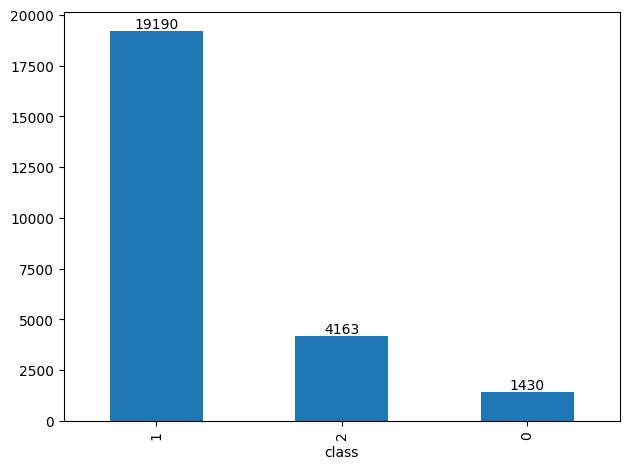

In [30]:
class_count = df['class'].value_counts()

ax = class_count.plot(kind='bar')

for i, value in enumerate(class_count):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

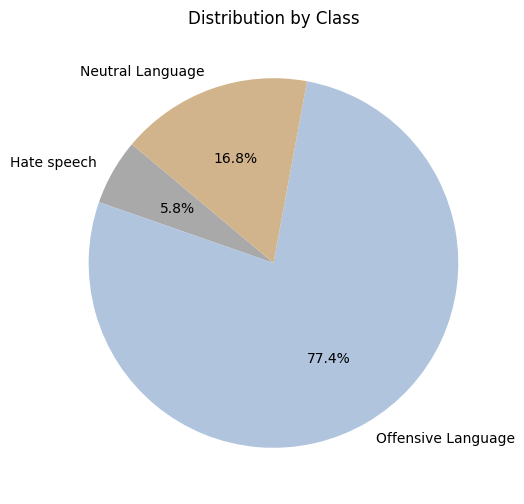

In [31]:
data = [1430, 19190, 4163]
labels = ['Hate speech', 'Offensive Language', 'Neutral Language']

colors = ['#A9A9A9', '#B0C4DE', '#D2B48C']

plt.figure(figsize=(6, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution by Class')
plt.show()

In [32]:
display(df.iloc[:5, :2]) # .iloc[row_indexer, column_indexer]

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = "/content/drive/MyDrive/frequency_dictionary_en_82_765.txt"  # path to the downloaded dictionary
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

#p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        # Skip short words and stopwords to speed up
        if len(word) < 3 or word in stop_words:
            corrected_words.append(word)
            continue

        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional: keep the text if you want)
    text = re.sub(r'#\w+', '', text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text).strip()
    text = correct_spelling_symspell(text)
    pattern = r'([{}])\1+'.format(re.escape(punctuation))
    text = re.sub(pattern, r'\1', text)
    tokens = tokenizer.tokenize(text)
    words = [w for w in tokens if w not in stop_words]
    return " ".join(words)

df['tweet_cleaned'] = df['tweet'].apply(clean_tweet)

In [35]:
df['tweet_cleaned'] = df['tweet_cleaned'].str.replace(r'!\s*rt\s*:', '', regex=True).str.replace(r"[^\w\s.,!?']", "", regex=True)

In [36]:
df['tweet_cleaned'] = df['tweet_cleaned'].str.replace(r'\brt\b', '', regex=True).str.strip() # added line after checking more common words in 'tweet_cleaned' column

In [37]:
df

,class,tweet,tweet_cleaned
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,woman complain cleaning house camp man always take trash .
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,boy date cold.tyga bad coffin dat hoe st place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,! dawg ever fuck bitch start cry confused shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,look like granny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,shit hear might true might faker bitch told ya
...,...,...,...
24778,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;",muthaf lie rights tl trash . mine bible scriptures hymns
24779,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy",gone broke wrong heart baby drove redneck crazy
24780,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,young buck wanna eat ! . dat nigga like int fucking dis
24781,1,youu got wild bitches tellin you lies,got wild bitches telling lies


In [38]:
df.groupby('class').nunique()

,tweet,tweet_cleaned
class,,
0,1430,1372
1,19190,18422
2,4163,4053


In [39]:
df = df.drop_duplicates(subset='tweet_cleaned', keep='first').reset_index(drop=True)

In [40]:
df.groupby('class').nunique()

,tweet,tweet_cleaned
class,,
0,1349,1349
1,18404,18404
2,4046,4046


In [41]:
df.drop('tweet', inplace = True, axis=1)

In [42]:
df = df.drop_duplicates(subset='tweet_cleaned', keep='first').reset_index(drop=True)

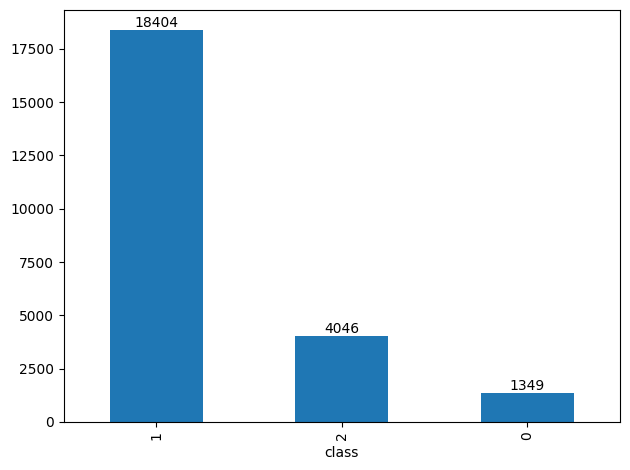

In [43]:
class_count = df['class'].value_counts()

ax = class_count.plot(kind='bar')

for i, value in enumerate(class_count):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [44]:
df.head()

,class,tweet_cleaned
0,2,woman complain cleaning house camp man always take trash .
1,1,boy date cold.tyga bad coffin dat hoe st place
2,1,! dawg ever fuck bitch start cry confused shit
3,1,look like granny
4,1,shit hear might true might faker bitch told ya


##### <span style="color:#483D8B; font-weight:bold;">Visualizations for insights with NLP techniques</span>


##### <span style="color:#483D8B; font-weight:bold;">Word cloud</span>

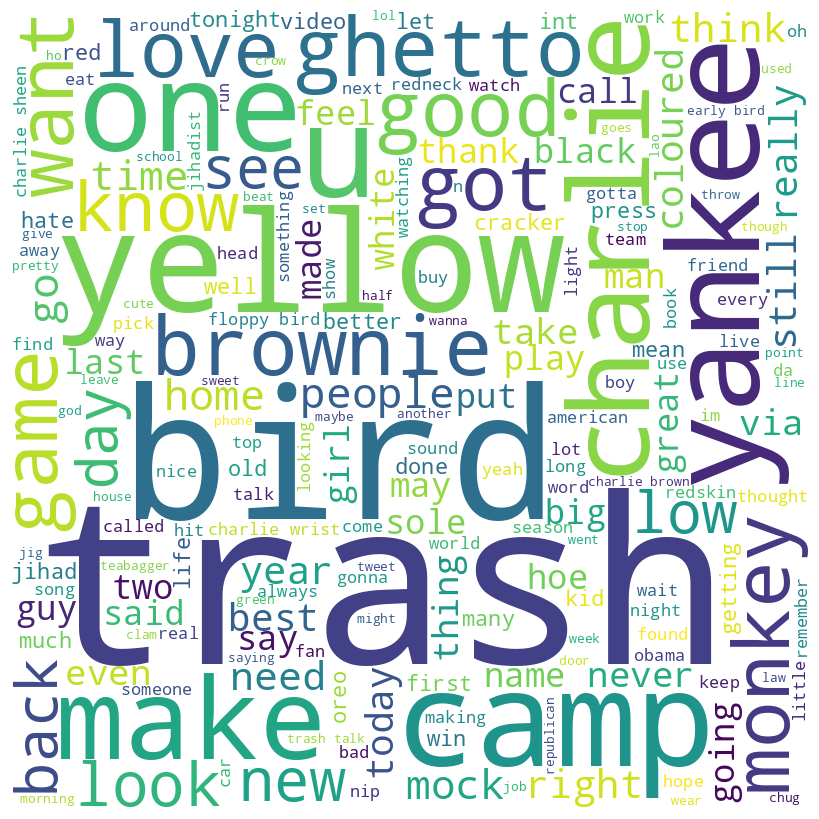

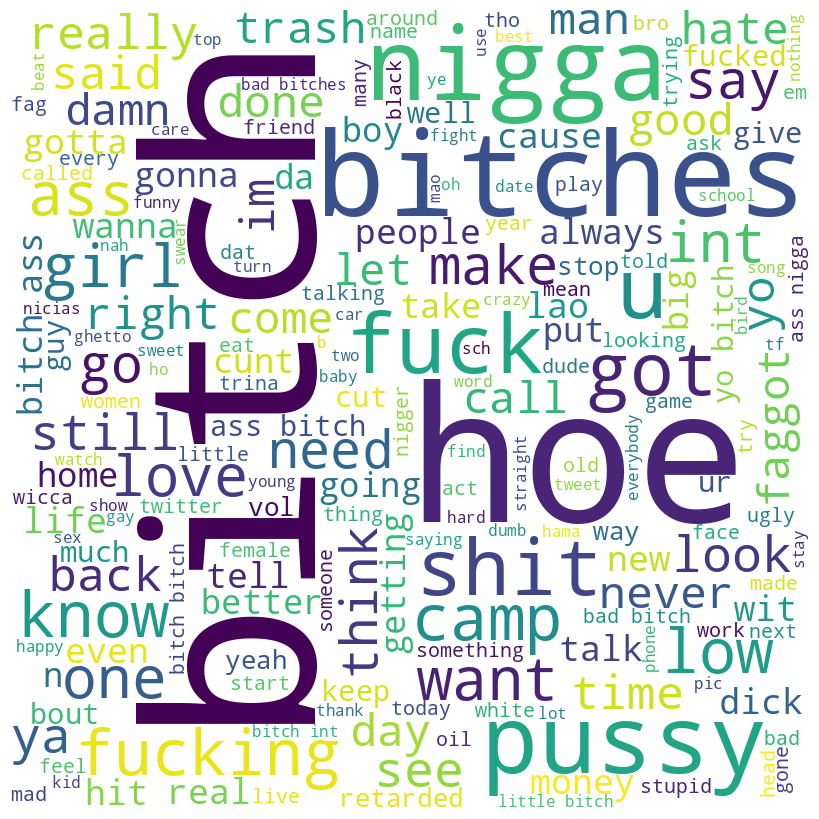

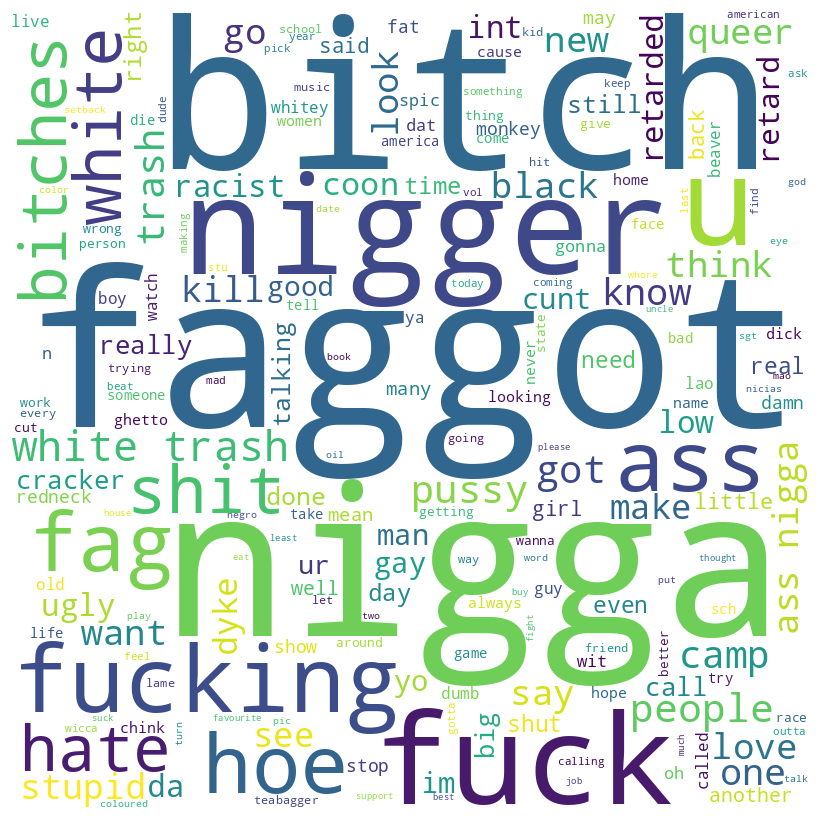

In [45]:
for c in df['class'].unique():
  test = ' '.join(df[df['class'] == c]['tweet_cleaned'])
  wordcloud = WordCloud(width=800, height=800, background_color='white').generate(test)

  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)

##### <span style="color:#483D8B; font-weight:bold;">Top Words per Class

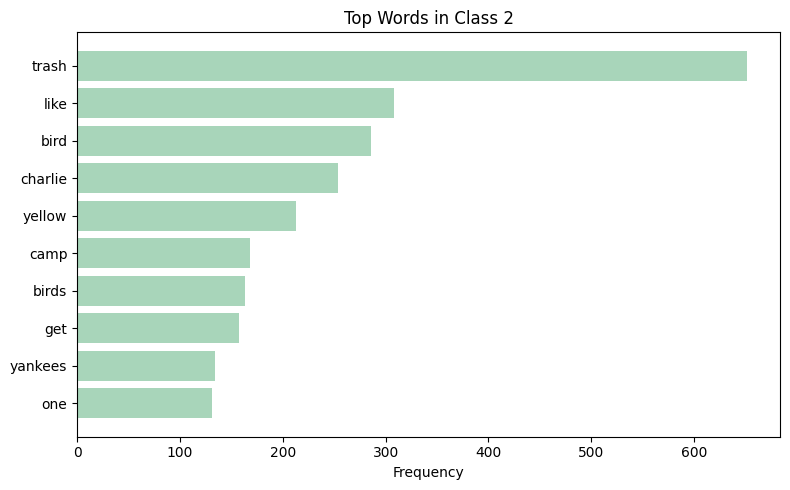

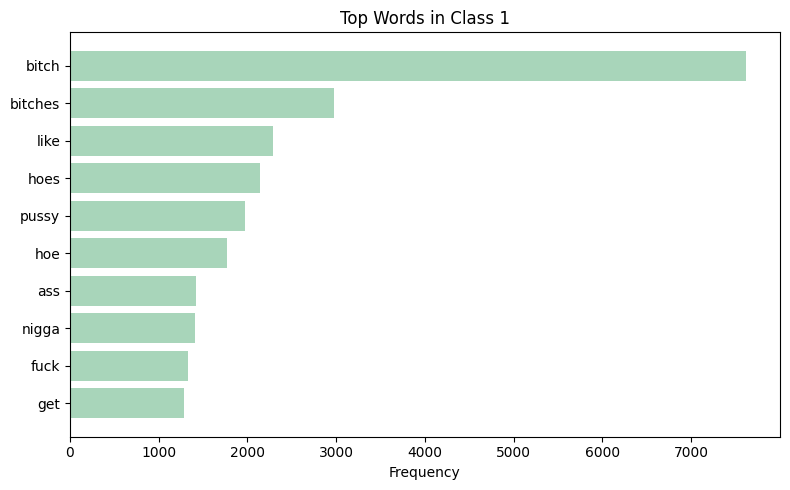

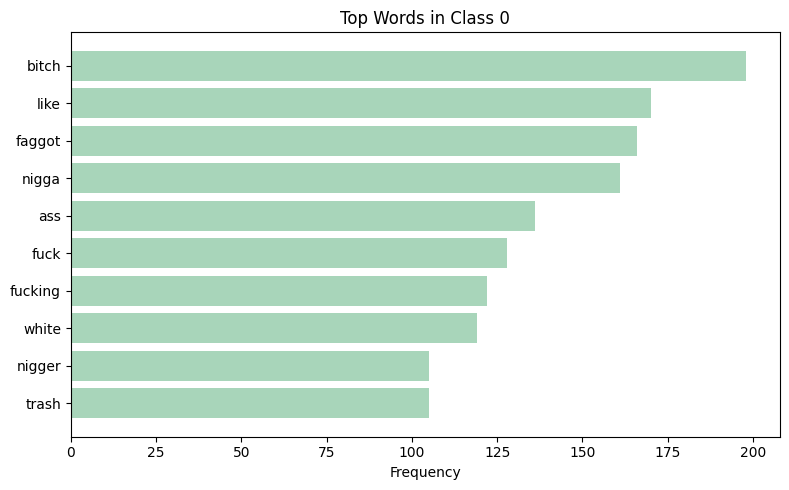

In [46]:
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=10):
    words = " ".join(texts).split()
    words = [re.sub(r'[^\w\s]', '', w.lower()) for w in words]
    words = [w for w in words if w and w not in stop_words]
    return Counter(words).most_common(n)

for c in df['class'].unique():
    top_words = get_top_words(df[df['class'] == c]['tweet_cleaned'])
    words, freqs = zip(*top_words)

    plt.figure(figsize=(8, 5))
    plt.barh(words, freqs, color='#A8D5BA')
    plt.gca().invert_yaxis()
    plt.title(f"Top Words in Class {c}")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

##### <span style="color:#483D8B; font-weight:bold;">Sentiment Analysis -1 (negative) to +1 (positive)

In [47]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [48]:
sia = SentimentIntensityAnalyzer() # VADER sentiment analyzer from NLTK

df['sentiment'] = df['tweet_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])
print(df[['class', 'sentiment']].groupby('class').mean())

       sentiment
class           
0      -0.384861
1      -0.364421
2       0.069358


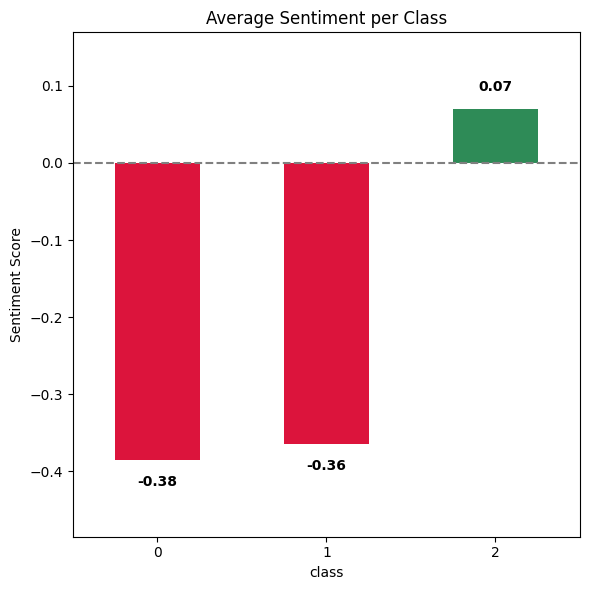

In [49]:
# Sentiment values (replace with your actual values if needed)
sentiment_avg = df.groupby('class')['sentiment'].mean()

colors = ['crimson' if val < 0 else 'seagreen' for val in sentiment_avg]

plt.figure(figsize=(6, 6))
ax = sentiment_avg.plot(kind='bar', color=colors)

# Add sentiment values as text
for i, value in enumerate(sentiment_avg):
    va = 'bottom' if value >= 0 else 'top'
    y_offset = 0.02 if value >= 0 else -0.02
    ax.text(i, value + y_offset, f'{value:.2f}', ha='center', va=va, fontweight='bold')

plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Sentiment per Class')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=0)
plt.ylim(sentiment_avg.min() - 0.1, sentiment_avg.max() + 0.1)
plt.tight_layout()
plt.show()

##### TF-IDF / Term Frequency - Inverse Document Frequency

In [50]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = tfidf.fit_transform(df['tweet_cleaned'])

feature_names = tfidf.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df_tfidf = df_tfidf[(df_tfidf != 0).any(axis=1)]  # filter out rows with all zeros

# Show most important words overall
print("Top TF-IDF words across all tweets:")
print(df_tfidf.sum().sort_values(ascending=False))

Top TF-IDF words across all tweets:
bitch      5978.703127
bitches    2502.691816
like       1958.034399
hoes       1869.248765
pussy      1707.805655
hoe        1534.104371
nigga      1120.858091
ass        1116.127610
fuck       1059.309873
shit        920.441005
dtype: float64


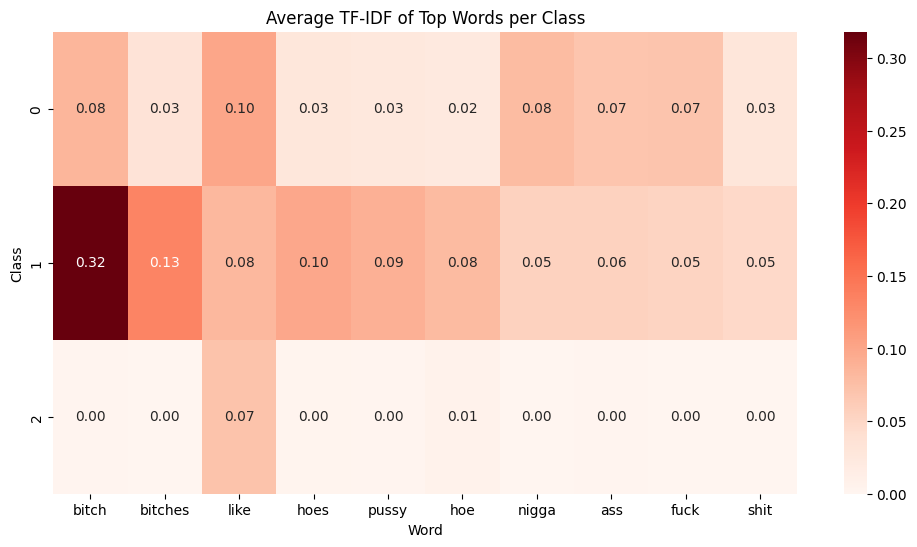

In [51]:
# Your list of top words
top_words = ['bitch', 'bitches', 'like', 'hoes', 'pussy', 'hoe', 'nigga', 'ass', 'fuck', 'shit']

# Vectorize all tweets to get TF-IDF matrix and feature names
tfidf = TfidfVectorizer(vocabulary=top_words)  # Limit vocab to top words
X = tfidf.fit_transform(df['tweet_cleaned'])
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame from TF-IDF matrix for convenience
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Add class labels
tfidf_df['class'] = df['class'].values

# Calculate average TF-IDF per word per class
avg_tfidf_per_class = tfidf_df.groupby('class').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(avg_tfidf_per_class, annot=True, cmap='Reds', fmt='.2f')
plt.title('Average TF-IDF of Top Words per Class')
plt.ylabel('Class')
plt.xlabel('Word')
plt.show()

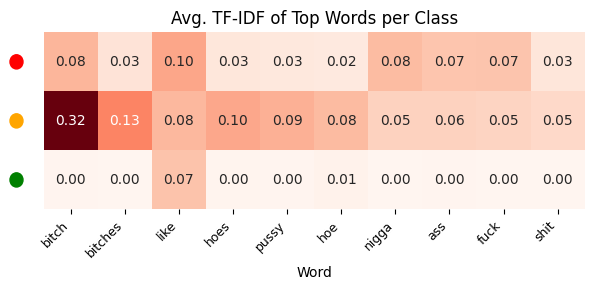

In [52]:
from matplotlib.patches import Circle

plt.figure(figsize=(6, 3))

ax = sns.heatmap(avg_tfidf_per_class, annot=True, cmap='Reds', fmt='.2f', cbar=False, yticklabels=False)

class_colors = ['red', 'orange', 'green']

for y, color in enumerate(class_colors):
    circle = Circle((-0.5, y + 0.5), 0.12, color=color, transform=ax.transData, clip_on=False)
    ax.add_patch(circle)

ax.set_ylabel('')
ax.set_yticks([])

plt.title('Avg. TF-IDF of Top Words per Class', fontsize=12)
plt.xlabel('Word', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd

top_words = ['bitch', 'bitches', 'like', 'hoes', 'pussy', 'hoe', 'nigga', 'ass', 'fuck', 'shit']

# Prepare a list to collect rows
rows = []

for word in top_words:
    for c in sorted(df['class'].unique()):
        examples = df[(df['class'] == c) & (df['tweet_cleaned'].str.contains(fr'\b{word}\b', case=False, na=False))]
        for tweet in examples['tweet_cleaned'].head(3):  # up to 3 examples
            rows.append({'word': word, 'class': c, 'tweet': tweet})

# Create a DataFrame from the collected rows
examples_df = pd.DataFrame(rows)

# Show the DataFrame
examples_df

,word,class,tweet
0,bitch,0,stacey cash baddest bitch vaasa
1,bitch,0,worry nigga see worry nigga see . rates da nigga fucking yo bitch
2,bitch,0,ol trout mouth ass bitch deeeaaadd
3,bitch,1,! dawg ever fuck bitch start cry confused shit
4,bitch,1,shit hear might true might faker bitch told ya
...,...,...,...
82,shit,1,shit hear might true might faker bitch told ya
83,shit,1,! shit blows me.claim faithful somebody still fucking hoes
84,shit,2,overdosing heavy drugs sound bad tonight pussy shit every day
85,shit,2,watched single episode however watching reunion coon shit mean levels ratcheticity


Bigrams - Pairs of consecutive words

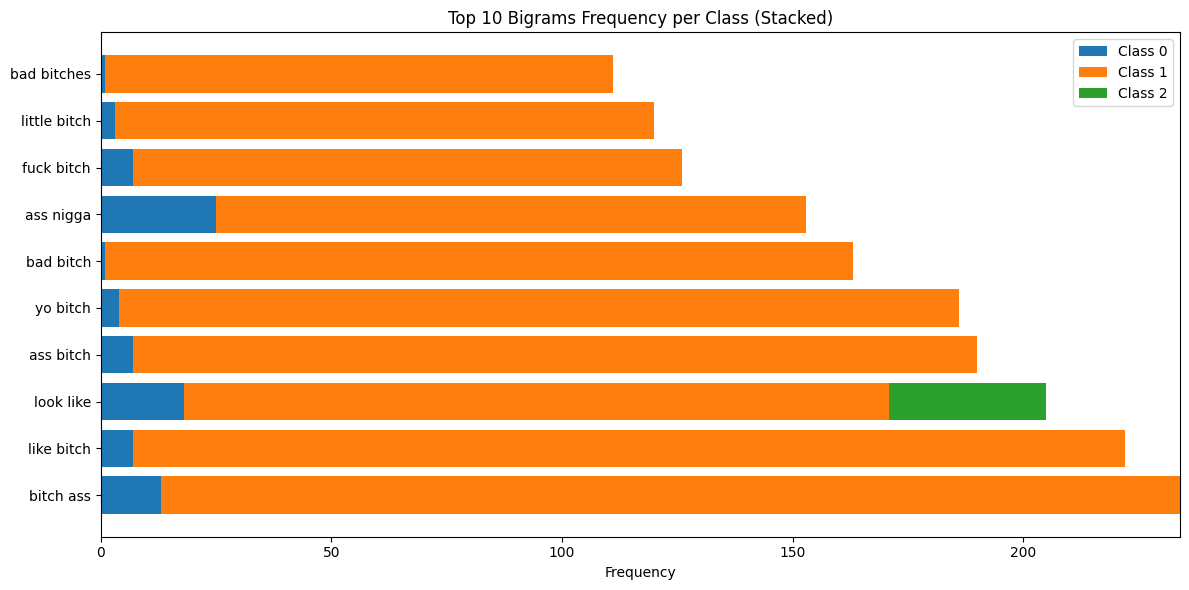

In [54]:
# All classes
classes = sorted(df['class'].unique())

# Fit CountVectorizer on entire dataset to get vocabulary
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['tweet_cleaned'])
bigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Get top 10 bigrams overall
bigram_freq = sorted(zip(bigrams, counts), key=lambda x: x[1], reverse=True)[:10]
top_bigrams, _ = zip(*bigram_freq)

# Now get counts for these bigrams per class
class_counts = []
for c in classes:
    # Vectorize only tweets from class c, using the SAME vocabulary to align features
    Xc = CountVectorizer(ngram_range=(2, 2), stop_words='english', vocabulary=top_bigrams).fit_transform(df[df['class'] == c]['tweet_cleaned'])
    class_counts.append(Xc.toarray().sum(axis=0))

# Convert to numpy array for easier plotting: shape = (num_classes, num_bigrams)
class_counts = np.array(class_counts)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(top_bigrams))
colors = ['tab:blue', 'tab:orange', 'tab:green']  # Adjust colors if you have more classes

for i, c in enumerate(classes):
    ax.barh(top_bigrams, class_counts[i], left=bottom, color=colors[i], label=f'Class {c}')
    bottom += class_counts[i]

ax.set_xlabel('Frequency')
ax.set_title('Top 10 Bigrams Frequency per Class (Stacked)')
ax.legend()
plt.tight_layout()
plt.show()

In [55]:
phrase = "bitch ass"

# Filter rows where 'tweet_cleaned' contains the exact phrase (case-insensitive)
examples = df[df['tweet_cleaned'].str.contains(r'\b' + phrase + r'\b', case=False, na=False)]

# Select relevant columns: class and tweet
examples_df = examples[['class', 'tweet_cleaned']].rename(columns={'tweet_cleaned': 'tweet'})

examples_df

,class,tweet
60,1,probably mind school much deal bitch ass teachers
69,1,fuck red alone man bitch ass nigga could please use complete sentences
153,1,stop scared choke sex u bitch ass niggas like . . days guy hits women bed foh
168,1,shut yo bitch ass
209,1,yo girl cant homeboys ol weak bitch ass nigga
...,...,...
23243,1,making shittiest pigs blanket gonna good trina impress gordon ramsey's bitch ass trying make poop
23286,1,n cant even enjoy reg house hunters 1 fax shows.because know house hunters international bitch ass comes next
23305,0,niggas int playing gram defense man george need tell bitch ass niggas man
23415,1,rams fiona smack steven jackson bitch ass


LDA - there is an interactive pyLDAvis

In [56]:
count_vec = CountVectorizer(stop_words='english')
X = count_vec.fit_transform(df['tweet_cleaned'])

lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(X)

for i, topic in enumerate(lda.components_):
    words = [count_vec.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic #{i}: {', '.join(words)}")

KeyboardInterrupt: 

In [ ]:
doc_topic_dists = lda.transform(X)
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]
doc_lengths = X.sum(axis=1).A1
vocab = count_vec.get_feature_names_out()
term_frequency = np.array(X.sum(axis=0)).flatten()

vis = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency
)

pyLDAvis.display(vis)

##### <span style="color:#483D8B; font-weight:bold;">Model building</span>

##### <span style="color:#483D8B; font-weight:bold;">1 - Handling Imbalanced Data</span>

In [57]:
multi_class_tweets = df.groupby('tweet_cleaned')['class'].nunique()

tweets_with_multiple_classes = multi_class_tweets[multi_class_tweets > 1]

print(tweets_with_multiple_classes) # the same tweet with multiple classes

Series([], Name: class, dtype: int64)


In [58]:
df_0 = df[df['class'] == 0]   # All hate speech tweets
df_1 = df[df['class'] == 1]   # All offensive tweets
df_2 = df[df['class'] == 2]   # All neutral tweets

In [59]:
max_size = df_1.shape[0]
max_size

18404

In [60]:
df.head()

,class,tweet_cleaned,sentiment
0,2,woman complain cleaning house camp man always take trash .,-0.3612
1,1,boy date cold.tyga bad coffin dat hoe st place,-0.5423
2,1,! dawg ever fuck bitch start cry confused shit,-0.9485
3,1,look like granny,0.3612
4,1,shit hear might true might faker bitch told ya,-0.6808


In [61]:
df = df.drop(columns=['sentiment'])

In [62]:
df.groupby('class').nunique()

,tweet_cleaned
class,
0,1349
1,18404
2,4046


The model needs to be trained on additional data to predict subtle hate speech, various examples were checked at the evaluation stage, and the model couldn't spot them. New dataset to be added with subtle hatespeech examples (source huggingface)

In [63]:
path3 = "/content/drive/MyDrive/subtle_hp_dataset.csv"

In [64]:
df2 = pd.read_csv(path3, low_memory=False) # low memory for more more accurate type inference

In [65]:
df2.head()

,cleaned_text,class
0,"i suppose they re trying to be funny , but it s really just an effort to continue demonizing germans and propagating the holocau $ t .",0
1,i think the uk is more of a lost cause than the us . london has made tons of concessions to non whites .,0
2,"for all the people who believe that without migration nhs cannot do it , i would like to tell you that we have already done it in history ! precisely before the s and before tony blair",0
3,"sometimes i wonder if it is because whites are so much smarter that they find it harder to run together , as opposed to , independently .",0
4,"this is the new normal . we accept homosexuality in our schools and in our neighbourhoods . we accept it in our workplaces and in our houses . what is the problem ? no problem , if we are not interested in a decent society .",0


In [66]:
df2.shape

(55, 2)

In [67]:
# Apply the same cleanning process like in df

max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = "/content/drive/MyDrive/frequency_dictionary_en_82_765.txt"  # path to the downloaded dictionary
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        if len(word) < 3 or word in stop_words:
            corrected_words.append(word)
            continue

        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional: keep the text if you want)
    text = re.sub(r'#\w+', '', text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text).strip()
    text = correct_spelling_symspell(text)
    pattern = r'([{}])\1+'.format(re.escape(punctuation))
    text = re.sub(pattern, r'\1', text)
    tokens = tokenizer.tokenize(text)
    words = [w for w in tokens if w not in stop_words]
    return " ".join(words)

df2['tweet_cleaned'] = df2['cleaned_text'].apply(clean_tweet)

In [68]:
df2 = df2.drop(columns=['cleaned_text'])
df2.head(2)

,class,tweet_cleaned
0,0,"suppose trying funny , really effort continue demonizing germans propagating holocaust $ ."
1,0,think uk lost cause us . london made tons concessions non whites .


In [69]:
df = pd.concat([df, df2], ignore_index=True)

In [70]:
df.shape

(23854, 2)

In [71]:
df = df.drop_duplicates(subset='tweet_cleaned', keep='first').reset_index(drop=True)

Step completed to add new dataset to df, continueing with the balancing your data

In [72]:
df.groupby('class').nunique() # total number matches

,tweet_cleaned
class,
0,1404
1,18404
2,4046


In [73]:
# splitting again per class

df_0 = df[df['class'] == 0]   # All hate speech tweets
df_1 = df[df['class'] == 1]   # All offensive tweets
df_2 = df[df['class'] == 2]   # All neutral tweets

In [74]:
df_0_upsampled = resample(df_0, replace=True, n_samples=max_size, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=max_size, random_state=42)

In [75]:
df_balanced = pd.concat([df_0_upsampled, df_2_upsampled, df_1])

In [76]:
df_balanced.groupby('class').count()

,tweet_cleaned
class,
0,18404
1,18404
2,18404


In [77]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [78]:
df_balanced.groupby('class').count()

,tweet_cleaned
class,
0,18404
1,18404
2,18404


In [79]:
df_balanced.head(2)

,class,tweet_cleaned
0,2,god still share mos 37 blessings
1,1,happy birthday nicest faggot ever


In [80]:
df_balanced["char_length"] = df_balanced["tweet_cleaned"].apply(len)
print(df_balanced["char_length"].describe()) # to find the max length for the model

count    55212.000000
mean        46.763910
std         24.940736
min          0.000000
25%         27.000000
50%         43.000000
75%         65.000000
max        184.000000
Name: char_length, dtype: float64


##### <span style="color:#483D8B; font-weight:bold;">2 - RoBERTa model bulding</span>

Using a lighter version or Roberta, distilroberta-base

In [81]:
df_reduced = df_balanced.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42)).reset_index(drop=True) #changed from 0.7 to 0.8

/tmp/ipython-input-81-3070809943.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df_balanced.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42)).reset_index(drop=True) #changed from 0.7 to 0.8


In [82]:
df_reduced = df_reduced.drop(columns=['char_length'])

In [83]:
df_reduced.groupby('class').count()

,tweet_cleaned
class,
0,14723
1,14723
2,14723


In [84]:
X = df_reduced["tweet_cleaned"]
y = df_reduced["class"]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [86]:
#tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [87]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=190) # changed the length (actuals length 147)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=190)

In [88]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, y_train)
test_dataset = TweetDataset(test_encodings, y_test)

In [89]:
config = RobertaConfig.from_pretrained(
        "distilroberta-base",
        num_labels=3,
        hidden_dropout_prob=0.3,                  # Increase dropout to help prevent overfitting
        attention_probs_dropout_prob=0.3          # Dropout in attention layers too
)

In [90]:
#model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", config=config)
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", config=config)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
training_args = TrainingArguments(
    output_dir='./results',  # Where to save model outputs and checkpoints
    num_train_epochs=8,     # Train up to 8 epochs - this is the best checkpoint (initially it was 10)
    per_device_train_batch_size=20, # Number of samples per batch for training
    per_device_eval_batch_size=20, # Number of samples per batch for evaluation
    logging_dir='./logs',          # Directory for training logs
    logging_steps=1000,             # Log training info every 1000 steps
    # no_cuda=True  # to force CPU usage if needed
    eval_strategy="epoch",              # Run evaluation after every epoch to check model performance
    save_strategy="epoch",                    # Save model checkpoint after each epoch
    load_best_model_at_end=True,              # After training, load the checkpoint with best evaluation loss!! (Check this again)
    metric_for_best_model="eval_loss",        # Use evaluation loss to determine which checkpoint is best
    weight_decay=0.01                         # Add weight decay (L2 regularization) to prevent overfitting
)

In [97]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2                 # Stop training if eval loss does not improve for 2 consecutive epochs
)

In [98]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [99]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,          # function for evaluating metrics
    callbacks=[early_stopping],               # Enable early stopping during training
)

In [99]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gkoutroumanos (gkoutroumanos-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.633800,0.432050,0.847181,0.846327,0.853060,0.847181
2,0.403200,0.318154,0.887820,0.888004,0.890274,0.887820
3,0.324400,0.301429,0.908875,0.908895,0.911882,0.908875
4,0.272700,0.264181,0.925741,0.925340,0.928912,0.925741
5,0.238900,0.235427,0.937967,0.937496,0.939959,0.937967
6,0.209400,0.230335,0.947136,0.946908,0.947584,0.947136
7,0.183400,0.202349,0.949287,0.949011,0.950131,0.949287
8,0.172300,0.228162,0.949174,0.948830,0.950173,0.949174


TrainOutput(global_step=14136, training_loss=0.2976866592845474, metrics={'train_runtime': 3798.9534, 'train_samples_per_second': 74.41, 'train_steps_per_second': 3.721, 'total_flos': 1.045870496604648e+16, 'train_loss': 0.2976866592845474, 'epoch': 8.0})

#### <span style="color:#483D8B; font-weight:bold;">3 - Classification report per class</span>

In [101]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)

y_pred = predictions.predictions.argmax(axis=1)

y_true = predictions.label_ids

print(classification_report(y_true, y_pred, digits=4))

{'eval_loss': 0.20234893262386322, 'eval_model_preparation_time': 0.0017, 'eval_runtime': 20.7017, 'eval_samples_per_second': 426.729, 'eval_steps_per_second': 21.351}


First results: [452/452 00:17]
{'eval_loss': 0.22755973041057587, 'eval_model_preparation_time': 0.0015, 'eval_runtime': 17.9547, 'eval_samples_per_second': 503.155, 'eval_steps_per_second': 25.174}

 Second results: [442/442 00:21]
{'eval_loss': 0.21381445229053497, 'eval_model_preparation_time': 0.0017, 'eval_runtime': 21.1788, 'eval_samples_per_second': 417.115, 'eval_steps_per_second': 20.87}

#### <span style="color:#483D8B; font-weight:bold;">4 - Save model</span>

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
model.save_pretrained('/content/drive/MyDrive/best_model')
tokenizer.save_pretrained('/content/drive/MyDrive/best_model')

('/content/drive/MyDrive/best_model/tokenizer_config.json',
 '/content/drive/MyDrive/best_model/special_tokens_map.json',
 '/content/drive/MyDrive/best_model/vocab.json',
 '/content/drive/MyDrive/best_model/merges.txt',
 '/content/drive/MyDrive/best_model/added_tokens.json',
 '/content/drive/MyDrive/best_model/tokenizer.json')

In [105]:
save_path = '/content/drive/MyDrive/best_model'
print(f"Model and tokenizer saved to: {save_path}")

Model and tokenizer saved to: /content/drive/MyDrive/best_model


In [1]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/best_model')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/best_model')

NameError: name 'AutoModelForSequenceClassification' is not defined

#### <span style="color:#483D8B; font-weight:bold;">5 - Predictions Test Data

In [100]:
#reload model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
model_path = "/content/drive/MyDrive/best_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [102]:
len(test_dataset)

8834

In [103]:
predictions = trainer.predict(test_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gkoutroumanos (gkoutroumanos-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [104]:
logits = predictions.predictions
labels = predictions.label_ids

In [105]:
predicted_labels = np.argmax(logits, axis=1)

predicted_labels

array([0, 1, 2, ..., 0, 2, 0])

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2984
           1       0.96      0.90      0.92      2913
           2       0.97      0.97      0.97      2937

    accuracy                           0.95      8834
   macro avg       0.95      0.95      0.95      8834
weighted avg       0.95      0.95      0.95      8834



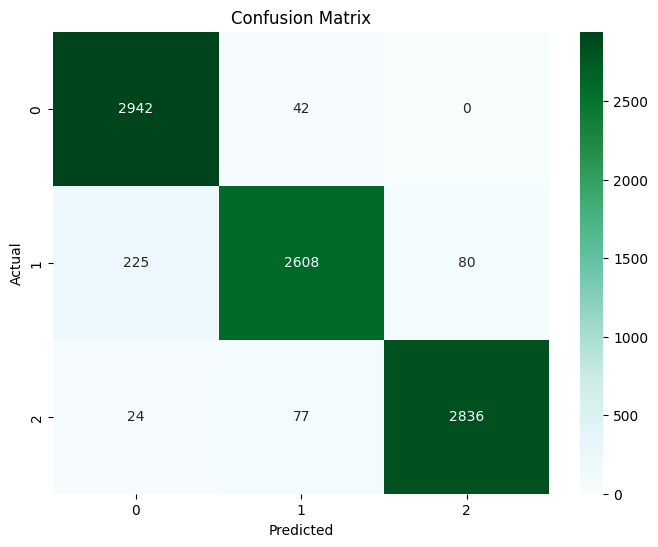

In [110]:
from sklearn.metrics import classification_report, confusion_matrix

# Run prediction
# predictions = trainer.predict(test_dataset)

# Get predicted class labels
preds = np.argmax(predictions.predictions, axis=1)

# Get true labels
true_labels = predictions.label_ids

# Print classification report
print(classification_report(true_labels, preds))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

CONCLUSIONS:

Class 0 (F1 = 0.95): high precision and very high recall.

Class 1 (F1 = 0.92): some true class 1 examples are being missed (recall = 0.89).

Class 2 (F1 = 0.97): both precision and recall are high.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('best_model')
tokenizer = AutoTokenizer.from_pretrained('best_model')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: best_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [111]:
print("Number of misclassified samples:", np.sum(preds != true_labels))

Number of misclassified samples: 448


In [112]:
X_test_reset = X_test.reset_index(drop=True)
misclassified_indices = np.where(preds != true_labels)[0]

print("Example misclassified tweet:", X_test_reset.iloc[misclassified_indices[0]])
print("True label:", true_labels[misclassified_indices[0]])
print("Predicted label:", preds[misclassified_indices[0]])

Example misclassified tweet: shut faggot
True label: 1
Predicted label: 0


In [113]:
from collections import defaultdict

misclassified_counts = defaultdict(int)
max_per_class = 10

for idx in np.where(preds != true_labels)[0]:
    true_class = true_labels[idx]
    pred_class = preds[idx]

    if misclassified_counts[true_class] < max_per_class:
        tweet_text = X_test_reset.iloc[idx]
        print(f"\nIndex {idx} | True: {true_class} | Pred: {pred_class}")
        print("Tweet:", tweet_text)

        # Explanation with LIME (optional - if explainer is defined)
        # explanation = explainer.explain_instance(
        #     tweet_text,
        #     classifier_fn=predict_proba_function,
        #     num_features=10
        # )
        # explanation.show_in_notebook(text=True)

        misclassified_counts[true_class] += 1

    if all(count >= max_per_class for count in misclassified_counts.values()):
        break


Index 78 | True: 1 | Pred: 0
Tweet: shut faggot

Index 120 | True: 1 | Pred: 0
Tweet: love hoes fuck niggas fucked

Index 131 | True: 1 | Pred: 0
Tweet: niggaz buying p  y.niggaz buying p  .  start hoe shit .

Index 132 | True: 2 | Pred: 1
Tweet: know told love project hoes

Index 146 | True: 0 | Pred: 1
Tweet: niggas int playing gram defense man george need tell bitch ass niggas man

Index 153 | True: 2 | Pred: 1
Tweet: early bitch driving denton org move already

Index 156 | True: 1 | Pred: 0
Tweet: nigga fuck hoe , ion want fuck yo hoe , fat chick camp bad built

Index 188 | True: 0 | Pred: 1
Tweet: shady bitches talk guys w  girlfriends that's disrespectful another girl

Index 212 | True: 1 | Pred: 0
Tweet: turning new leaf drama still faggot

Index 217 | True: 1 | Pred: 0
Tweet: might infected   niggas would really turn pussy ? buggin

Index 230 | True: 1 | Pred: 0
Tweet: fuck east st john fans family , camp friends shut yo bitch ass

Index 235 | True: 1 | Pred: 2
Tweet: julia ro

In [114]:
df[df['tweet_cleaned'].str.contains('julia roberts', case=False, na=False)] # predicted classification more accurate

,class,tweet_cleaned
514,1,julia roberts
1578,1,orangutan tried sex actress julia roberts . smart monkey
13610,2,julia roberts seem completely shocked nominated key julia gown jig


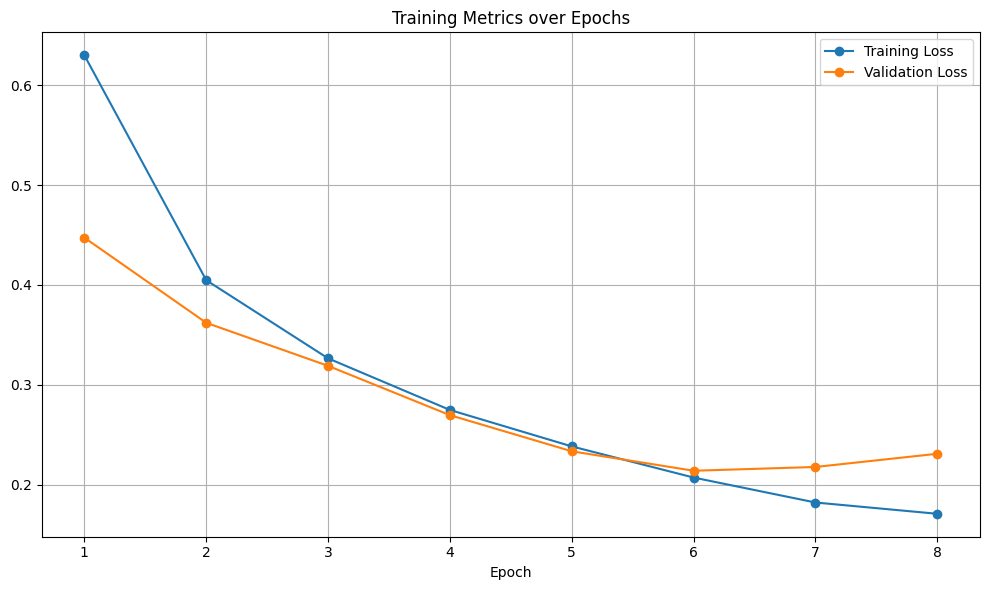

In [ ]:
(add code again deleted accidentally)

#### <span style="color:#483D8B; font-weight:bold;">6 - validate example subtle hate speech

In [115]:
from transformers import pipeline

In [116]:
classifier = pipeline("text-classification", model="/content/drive/MyDrive/best_model", tokenizer="/content/drive/MyDrive/best_model") # Load the pipeline with your saved model

texts = [
    "Some groups just don’t deserve the same rights as others.",
    "Oh sure, let's put another brilliant woman in charge, what could possibly go wrong.",
    "They’re always playing the victim card. You know the group I mean.",
    "I love how Asians are always good at math. Wish I had that gene!",
    "I identify as a toaster now. Respect my pronouns, lol.",
    "Some cultures just don’t value education like we do."
]

for text in texts:
    result = classifier(text)[0]
    print(f"Text: {text}")
    print(f"→ Class: {result['label']} | Confidence: {result['score']:.4f}")
    print("-" * 80)

Device set to use cpu


Text: Some groups just don’t deserve the same rights as others.
→ Class: LABEL_0 | Confidence: 0.9956
--------------------------------------------------------------------------------
Text: Oh sure, let's put another brilliant woman in charge, what could possibly go wrong.
→ Class: LABEL_1 | Confidence: 0.4100
--------------------------------------------------------------------------------
Text: They’re always playing the victim card. You know the group I mean.
→ Class: LABEL_2 | Confidence: 0.9934
--------------------------------------------------------------------------------
Text: I love how Asians are always good at math. Wish I had that gene!
→ Class: LABEL_0 | Confidence: 0.9720
--------------------------------------------------------------------------------
Text: I identify as a toaster now. Respect my pronouns, lol.
→ Class: LABEL_2 | Confidence: 0.9759
--------------------------------------------------------------------------------
Text: Some cultures just don’t value education

CONCLUSION:

Model improved on identifying subtle hate speech but it needs further improvement as it misclassified some key example like "Text: I identify as a toaster now. Respect my pronouns, lol."

#### <span style="color:#483D8B; font-weight:bold;">Improt Data obtained via Reddit API

In [ ]:
file_path = '/content/drive/MyDrive/reddit_comments.csv'

df_rd = pd.read_csv(file_path)

df_rd.head()

,comment
0,"lol lifted up his shirt to show his gun. Hey 6 year old bud, don’t try anything, I’m a super duper tough guy you little weakling. These people are just school bullies who never looked in the mirror and can’t find meaning in themselves so they try to bring down others to their level of misery."
1,How are the officers not completely ashamed and embarrassed by this. I guess I understand some people have literally zero empathy but it’s hard to wrap my head around
2,"*”They were crying in fear. One of the agents at one point lifted up his shirt, which displayed the gun that he was carrying,"" Mukherjee said. ""The 6-year-old boy was terrified to see the gun. He urinated on himself and wet all his clothing. No one offered him a change of clothing for many hours.""*\n\nTreating children like animals. Dignity for fellow humans has been lost, when it is gone for them it is gone for everyone. There is always another groups to find and mistreat after the thugs have finished with their current targets."
3,"Trump: ""Our focus is on the worst of the worst criminals to protect American citizens from criminals.""\n\n6 year old with leukemia has entered the chat."
4,">The family had been staying with a relative in Los Angeles for the previous seven months after **crossing the border legally** for a court appointment through the now-defunct CBP One App to seek asylum in October of last year. They had been **granted parole status in the U.S.** while they waited for their day in immigration court\n\n>The mother brought her two children to the immigration court on May 29 **expecting to continue to make a case for asylum** after fleeing Honduras due to threats of violence. But like many other immigrants across the country, they were surprised to see **their case quickly dismissed as ICE agents waited for them to step out of the courthouse** into the hallway\n\n>The Texas Civil Rights Project says the **family has been placed in expedited removal**, which allows for rapid deportation without a court hearing. The family's attorneys fear **they could be deported before their lawsuit is heard**\n\nThey came here legally. It was never about illegal immigration"


In [ ]:
df_rd.shape

(918, 1)

In [ ]:
df_rd.dtypes

,0
comment,object


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply the same cleanning process like in df

max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = "/content/drive/MyDrive/frequency_dictionary_en_82_765.txt"  # path to the downloaded dictionary
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        if len(word) < 3 or word in stop_words:
            corrected_words.append(word)
            continue

        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional: keep the text if you want)
    text = re.sub(r'#\w+', '', text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text).strip()
    text = correct_spelling_symspell(text)
    pattern = r'([{}])\1+'.format(re.escape(punctuation))
    text = re.sub(pattern, r'\1', text)
    tokens = tokenizer.tokenize(text)
    words = [w for w in tokens if w not in stop_words]
    return " ".join(words)

df_rd['cleaned_comment'] = df_rd['comment'].apply(clean_tweet)

#### <span style="color:#483D8B; font-weight:bold;">Predit class on Redit Data

In [ ]:
df_rd_2 = df_rd.drop(columns=['comment'])
df_rd_2

,cleaned_comment
0,low lifted shirt show gun key 6 year old bud try anything pm super duper tough guy little weakling people school bullies never looked mirror cant find meaning try bring others level misery
1,officers completely ashamed embarrassed guess understand people literally zero empathy hard wrap head around
2,"* ” crying fear one agents one point lifted shirt displayed gun carrying mukherjee said 6 - year-old boy terrified see gun urinated wet clothing one offered change clothing many hours . "" * creating children like animals dignity fellow humans lost gone gone everyone always another groups find mistreat thugs finished current targets"
3,trump focus worst worst criminals protect american citizens criminals 6 year old leukaemia entered chat
4,"family staying relative los angeles previous seven months crossing border legally court appointment now-defunct cbp one app seek asylum october last year granted parole status u . . * waited day immigration court mother brought two children immigration court may 29 expecting continue make case asylum fleeing honduras due threats violence like many immigrants across country surprised see case quickly dismissed ice agents waited step courthouse hallway texas civil rights project says family placed expedited removal * , allows rapid deportation without court hearing family attorneys fear could deported lawsuit heard came legally never illegal immigration"
...,...
913,jumping numbers way commit fraud banks investors
914,that's issues issues inflated number gave wrong impression statistics everyone including investors bankers government
915,utterly besides point
916,china iron grip local governments name iconic duo


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/best_model')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/best_model')

# Set model to evaluation mode
model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
comments = df_rd['comment'].tolist()

inputs = tokenizer(comments, padding=True, truncation=True, return_tensors="pt") # Neural networks process fixed-length inputs efficiently.

In [ ]:
predictions = []
batch_size = 20  # smaller batches use less memory

for i in range(0, len(df_rd_2), batch_size):
    batch = df_rd_2['cleaned_comment'][i:i+batch_size].tolist()
    inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    predictions.extend(preds.tolist())

df_rd_2['predicted_class'] = predictions
df_rd_2.head()

,cleaned_comment,predicted_class
0,low lifted shirt show gun key 6 year old bud try anything pm super duper tough guy little weakling people school bullies never looked mirror cant find meaning try bring others level misery,2
1,officers completely ashamed embarrassed guess understand people literally zero empathy hard wrap head around,2
2,"* ” crying fear one agents one point lifted shirt displayed gun carrying mukherjee said 6 - year-old boy terrified see gun urinated wet clothing one offered change clothing many hours . "" * creating children like animals dignity fellow humans lost gone gone everyone always another groups find mistreat thugs finished current targets",2
3,trump focus worst worst criminals protect american citizens criminals 6 year old leukaemia entered chat,2
4,"family staying relative los angeles previous seven months crossing border legally court appointment now-defunct cbp one app seek asylum october last year granted parole status u . . * waited day immigration court mother brought two children immigration court may 29 expecting continue make case asylum fleeing honduras due threats violence like many immigrants across country surprised see case quickly dismissed ice agents waited step courthouse hallway texas civil rights project says family placed expedited removal * , allows rapid deportation without court hearing family attorneys fear could deported lawsuit heard came legally never illegal immigration",2


In [ ]:
df_rd_2['predicted_class'].value_counts().sort_index()

,count
predicted_class,
0,96
1,97
2,725


In [ ]:
df_combined = df_rd.drop(columns=['cleaned_comment']).join(df_rd_2)

In [ ]:
df_combined

,comment,cleaned_comment,predicted_class
0,"lol lifted up his shirt to show his gun. Hey 6 year old bud, don’t try anything, I’m a super duper tough guy you little weakling. These people are just school bullies who never looked in the mirror and can’t find meaning in themselves so they try to bring down others to their level of misery.",low lifted shirt show gun key 6 year old bud try anything pm super duper tough guy little weakling people school bullies never looked mirror cant find meaning try bring others level misery,2
1,How are the officers not completely ashamed and embarrassed by this. I guess I understand some people have literally zero empathy but it’s hard to wrap my head around,officers completely ashamed embarrassed guess understand people literally zero empathy hard wrap head around,2
2,"*”They were crying in fear. One of the agents at one point lifted up his shirt, which displayed the gun that he was carrying,"" Mukherjee said. ""The 6-year-old boy was terrified to see the gun. He urinated on himself and wet all his clothing. No one offered him a change of clothing for many hours.""*\n\nTreating children like animals. Dignity for fellow humans has been lost, when it is gone for them it is gone for everyone. There is always another groups to find and mistreat after the thugs have finished with their current targets.","* ” crying fear one agents one point lifted shirt displayed gun carrying mukherjee said 6 - year-old boy terrified see gun urinated wet clothing one offered change clothing many hours . "" * creating children like animals dignity fellow humans lost gone gone everyone always another groups find mistreat thugs finished current targets",2
3,"Trump: ""Our focus is on the worst of the worst criminals to protect American citizens from criminals.""\n\n6 year old with leukemia has entered the chat.",trump focus worst worst criminals protect american citizens criminals 6 year old leukaemia entered chat,2
4,">The family had been staying with a relative in Los Angeles for the previous seven months after **crossing the border legally** for a court appointment through the now-defunct CBP One App to seek asylum in October of last year. They had been **granted parole status in the U.S.** while they waited for their day in immigration court\n\n>The mother brought her two children to the immigration court on May 29 **expecting to continue to make a case for asylum** after fleeing Honduras due to threats of violence. But like many other immigrants across the country, they were surprised to see **their case quickly dismissed as ICE agents waited for them to step out of the courthouse** into the hallway\n\n>The Texas Civil Rights Project says the **family has been placed in expedited removal**, which allows for rapid deportation without a court hearing. The family's attorneys fear **they could be deported before their lawsuit is heard**\n\nThey came here legally. It was never about illegal immigration","family staying relative los angeles previous seven months crossing border legally court appointment now-defunct cbp one app seek asylum october last year granted parole status u . . * waited day immigration court mother brought two children immigration court may 29 expecting continue make case asylum fleeing honduras due threats violence like many immigrants across country surprised see case quickly dismissed ice agents waited step courthouse hallway texas civil rights project says family placed expedited removal * , allows rapid deportation without court hearing family attorneys fear could deported lawsuit heard came legally never illegal immigration",2
...,...,...,...
913,Pumping up numbers is a way to commit fraud against banks and investors.,jumping numbers way commit fraud banks investors,2
914,"That's not the issue.\n\nThe issue, is that they inflated the number, which gave the wrong impression and statistics to everyone, including investors, bankers, and the government.",that's issues issues inflated number gave 

In [ ]:
pd.set_option('display.max_colwidth', None)
df_combined[df_combined['predicted_class'] == 0].sample(10)

,comment,cleaned_comment,predicted_class
609,"Fun fact, the judge also said that, ""Ms Lattouf’s making of the [Human Rights Watch] post was ill-advised and inconsiderate of her employer"".",sun fact judge also said lattouf ’ making human rights watch post ill-advised inconsiderate employer,0
481,I think they are basically unleashing mercenaries to profile and just snatch and grab without warrants or even a hint of PC. Otherwise why do they release so many of them?\n\nThe lie was they were going after the worst of the worst. Gang members and murderers and rapists,think basically unleashing mercenaries profile snatch grab without warrants even hint pc . otherwise release many lie going worst worst bang members murderers rapists,0
315,Do you think he’ll get deported to the US,think hell get deported us,0
299,Animal abusers are up there with child abusers. I think I hate animal abusers more than I hate those that kill adults.,animal abusers child abusers think hate animal abusers hate kill adults,0
444,Keep your kids off the internet. Its all predators.,keep kids internet predators,0
254,Liver Dude needs psychiatric help.,river nude needs psychiatric help,0
716,"Good, fucking asshole countrymen of mine should be held accountable.",good fucking ashore countrymen mine held accountable,0
237,"If this is true, I just don't know how any average American can look at this and not wonder if America has become a truly corrupt nation instead of a nation of laws, fairness and justice. A country worth being patriotic about and feeling pride in, rather than a nation where a minority of hateful souls run the show.",true know average american look wonder america become truly corrupt nation instead nation laws fairness justice country worth patriotic feeling pride rather nation minority hateful souls run show,0
192,"For the sake of argument, say she DID ""attack"" an officer. How does that justify keeping her detained without contact with anyone -- and not even telling family or a lawyer where she is held?\n\nIf she did attack someone, turn her over to a more relevant agency and press charges.\n\nAnd if she didn't, then what the fuck are you doing holding her at all?",sake argument say attack officer justify keeping detained without contact anyone - even telling family lawyer held attack someone turn relevant agency press charges fuck holding,0
47,"My 88 year old father still thinks a college degree means everything. It took him a while to understand that you can't just walk into a company with a resume anymore. And he doesn't quite understand that ageism is a problem. He changed careers in his late 50s in a field he had little experience in. My very educated 60 year old spouse is having trouble finding white collar work of any kind, likely due to age.",88 year old father still thinks college degree means everything took understand can't walk company resume anymore quite understand ageism problem changed careers late field little experience educated 60 year old spouse trouble finding white collar work kind likely due age,0


In [ ]:
sampled_df = df_combined.groupby('predicted_class').apply(lambda x: x.sample(30, random_state=42)).reset_index(drop=True)
sampled_df.to_csv('/content/drive/MyDrive/sampled_comments_per_class.csv')

/tmp/ipython-input-85-3269518975.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_combined.groupby('predicted_class').apply(lambda x: x.sample(30, random_state=42)).reset_index(drop=True)


#### <span style="color:#483D8B; font-weight:bold;">Create Streamlit App

In [117]:
!pip install --upgrade transformers safetensors streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.2 MB/s eta 0:00:00


In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
%%writefile app.py
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_PATH = "/content/drive/MyDrive/best_model"

@st.cache_resource
def load_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
    model.eval()
    return tokenizer, model

tokenizer, model = load_model_and_tokenizer()

device = torch.device("cpu")
model.to(device)

label_map = {0: "hate speech", 1: "offensive language", 2: "neutral language"}

st.title("Hate speech detector")

text = st.text_input("Enter text to classify:")

if st.button("Predict"):
    if not text.strip():
        st.warning("Please enter some text!")
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred_idx = torch.argmax(outputs.logits, dim=1).item()
        st.write("Prediction:", label_map.get(pred_idx, "Unknown"))

Writing app.py


In [120]:
!pip install -q streamlit pyngrok transformers

from pyngrok import ngrok
import subprocess
import time

# Set your ngrok authtoken
NGROK_AUTH_TOKEN = "2zNQYRoaf4qEKJ2xl3D6iPlUxoy_sFhQusi2Qyio9acW1J7D"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Start Streamlit in the background
proc = subprocess.Popen(['streamlit', 'run', 'app.py'])

# Open a tunnel on port 8501
public_url = ngrok.connect(8501).public_url

print(f"🚀 Your Streamlit app is live at: {public_url}")

# Keep the cell alive to maintain the tunnel
while True:
    time.sleep(60)

🚀 Your Streamlit app is live at: https://fea19e7e5589.ngrok-free.app


KeyboardInterrupt: 

#### <span style="color:#483D8B; font-weight:bold;">Create Streamlit App on local machine to be more stable for presenting - code below:

In [121]:
!zip -r best_model_final.zip /content/drive/MyDrive/best_model

  adding: content/drive/MyDrive/best_model/ (stored 0%)
  adding: content/drive/MyDrive/best_model/config.json (deflated 52%)
  adding: content/drive/MyDrive/best_model/model.safetensors (deflated 7%)
  adding: content/drive/MyDrive/best_model/tokenizer_config.json (deflated 75%)
  adding: content/drive/MyDrive/best_model/merges.txt (deflated 53%)
  adding: content/drive/MyDrive/best_model/special_tokens_map.json (deflated 52%)
  adding: content/drive/MyDrive/best_model/vocab.json (deflated 59%)
  adding: content/drive/MyDrive/best_model/tokenizer.json (deflated 82%)


In [122]:
from google.colab import files
files.download("/content/best_model_final.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>